# Projekt - Prepoznavanje raka pluća i debelog crijeva na slikama koristeći CNN


Prije svega, potrebno je učitati sve potrebne importe.

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.applications import ResNet50, MobileNetV2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-12-31 23:03:39.685189: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 23:03:39.830664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 23:03:39.830687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 23:03:39.855731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 23:03:39.908775: I tensorflow/core/platform/cpu_feature_guar

Dodatno, za slučaj da ne postoje, trebali bismo inicijalizirati direktorije gdje će biti pohranjeni modeli, kao i statistike vezane uz njih.

In [2]:
dirs = ['./models', './stats', './images']

for dir in dirs:
    if not os.path.exists(dir): 
        os.makedirs(dir)

Prije nego što krenemo učiti modele, potrebno je učitati skup podataka.

In [3]:
# data_folder = '/kaggle/input/neumre/data'
data_folder = './data'

file_paths = []
labels = []

class_folders = os.listdir(data_folder)
for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    class_files = os.listdir(class_folder_path)

    for file in class_files:
        file_path = os.path.join(class_folder_path, file)
        
        file_paths.append(file_path)
        
        if class_folder == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif class_folder == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif class_folder == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif class_folder == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif class_folder == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

file_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
data = pd.concat([file_series, label_series], axis=1)

print(data.describe())

                                filepath                 label
count                              25000                 25000
unique                             25000                     5
top     ./data/lung_scc/lungscc3298.jpeg  Colon Adenocarcinoma
freq                                   1                  5000


Možemo vizualizirati nekoliko slika kako bismo potvrdili da je učitavanje uspješno.

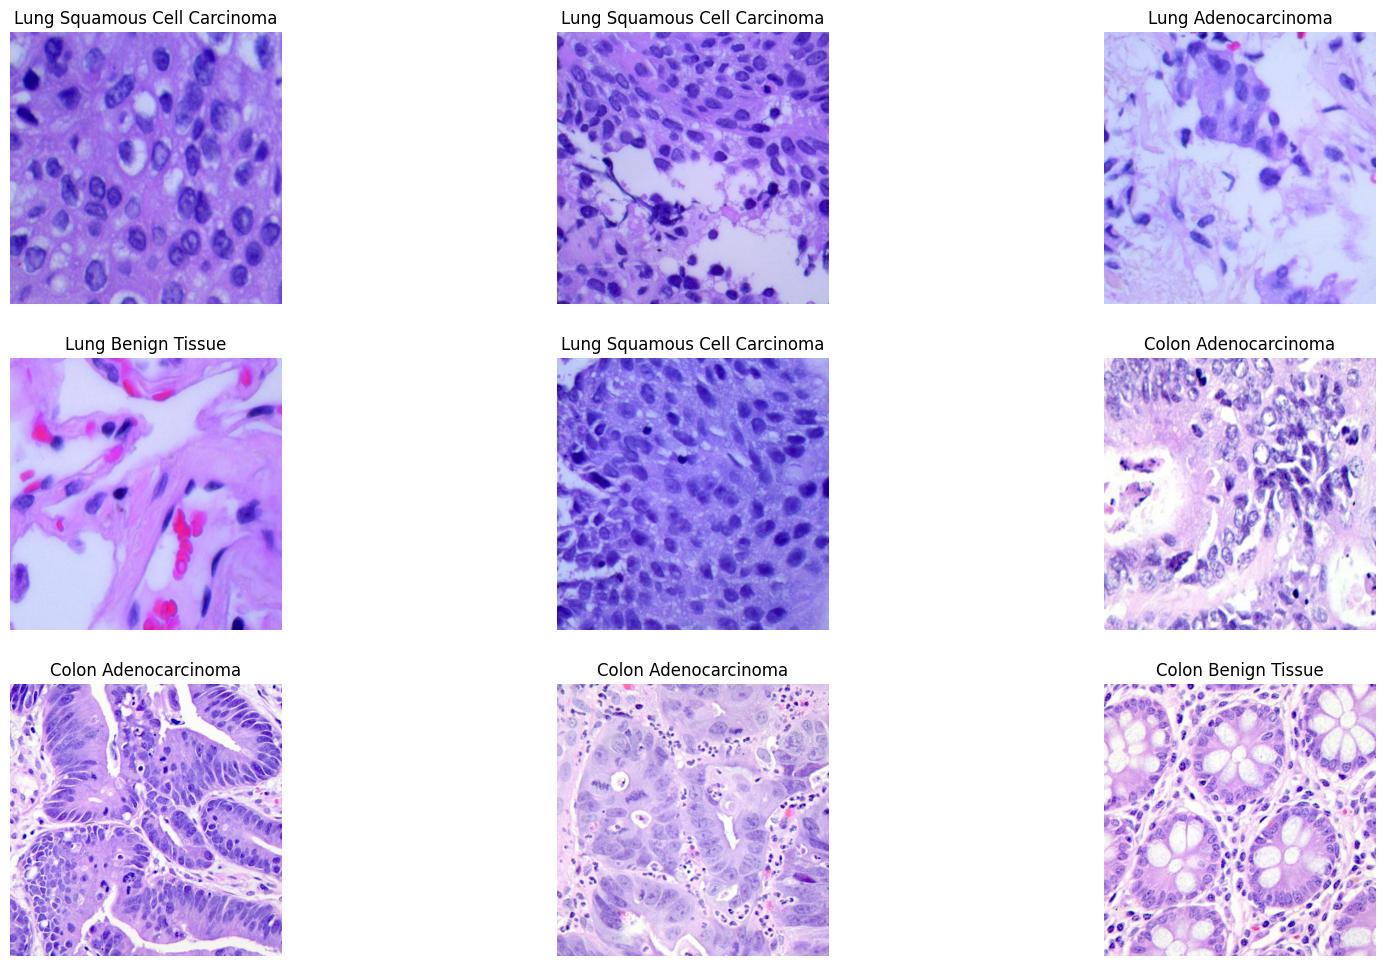

In [4]:
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(20,12))

for i in range(num_images):
    row_num = np.random.randint(0, data.shape[0])
    row = data.iloc[[row_num]]
    img = mpimg.imread(row['filepath'].item())

    plt.subplot(num_rows, num_cols, i + 1)
    plt.gca().set_title(row['label'].item())
    plt.gca().axis('off')
    plt.imshow(img)

plt.show()

Sljedeći korak je podijeliti skup podataka na tri disjunktna skupa: skup za učenje, ispitivanje i validaciju. 

In [5]:
train_data, temp_data = train_test_split(data, train_size=0.7, shuffle=True, random_state=100)
validation_data, test_data = train_test_split(temp_data,  train_size=1/3, shuffle=True, random_state=100)

Kada imamo sva tri skupa, potrebno je kreirati generatore koji će dohvaćati mini-grupe iz skupova, kao i obavljati dodatne poslove poput miješanja (shuffle) podataka. Kao veličinu mini-grupe stavit ćemo 16. Naravno, ovu veličinu možemo po volji podešavati.

In [6]:
batch_size = 16
image_size = (224, 224)
num_channels = 3

image_shape = (image_size[0], image_size[1], num_channels)
num_classes = 5

train_generator = ImageDataGenerator().flow_from_dataframe(train_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                           color_mode='rgb', shuffle=True, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow_from_dataframe(validation_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                                color_mode='rgb', shuffle=False, batch_size=batch_size)
test_generator = ImageDataGenerator().flow_from_dataframe(test_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

classes = list(train_generator.class_indices.keys())

Found 17500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


Found 5000 validated image filenames belonging to 5 classes.


Sljedeći korak nam je odabrati model. Kao prvi model odabrat ćemo ResNet50 model s težinama naučenim na ImageNet skupu. Ovaj model prilagodit ćemo našem problemu - na izlaz ćemo dodati nekoliko potpuno-povezanih slojeva (kao i sloj za normalizaciju te dropout sloj), od kojih će posljednji sloj imati broj izlaza jednak broju razreda. Tada će predikcija modela odgovarati izlazu s najvećom vrijednošću (aktivacijska funkcija u posljednjem sloju bit će softmax).

In [7]:
def get_resnet_50():
    pretrained_model = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = False

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='ResNet50')

    model.compile(Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

resnet50_model = get_resnet_50()
resnet50_model.summary()

2023-12-31 23:03:42.048393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 23:03:42.124492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 23:03:42.124529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 23:03:42.125710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 23:03:42.125740: I external/local_xla/xla/stream_executor

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                          

Sada možemo naučiti model, pritom koristeći skupove podataka za učenje i validaciju. Potrebno je odrediti broj epoha. Za početak ćemo isprobati učenje modela s ukupno 10 epoha. Pritom ćemo dodatno dodati dva callback-a: jedan za pohranu težina modela, a drugi za pohranu ispisa učenja u CSV formatu. Na kraju učenja, statistike modela (točnost, gubitak kroz epohe, itd.) ćemo pohraniti u zasebnu datoteku.

In [8]:
def train_model(model, num_epochs=10):
    dirs = ['./models', './stats', './images']

    for dir in dirs:
        if not os.path.exists(f'{dir}/{model.name}'): 
            os.makedirs(f'{dir}/{model.name}')

    checkpoint_saver = ModelCheckpoint(
        filepath=f'./models/{model.name}/model',
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True,
    )

    log_saver = CSVLogger(f'./stats/{model.name}/logs.csv')

    stats = model.fit(x=train_generator, epochs=num_epochs, validation_data=validation_generator, verbose=1, callbacks=[checkpoint_saver, log_saver])

    with open(f'./stats/{model.name}/stats.txt', 'wb') as file:
        pickle.dump(stats.history, file)

Definirajmo broj epoha i pokrenimo učenje.

In [9]:
num_epochs = 60
train_model(resnet50_model, num_epochs)

Epoch 1/60


2023-12-31 23:03:46.497241: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-31 23:03:47.214073: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-31 23:03:47.642398: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-31 23:03:48.976790: I external/local_xla/xla/service/service.cc:168] XLA service 0x4814a4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-31 23:03:48.976809: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-31 23:03:48.983522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704060229.042138     952 device_compiler.h:18

1094/1094 [==============================] - 55s 45ms/step - loss: 0.8755 - accuracy: 0.9210 - val_loss: 0.1629 - val_accuracy: 0.9700
Epoch 2/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2503 - accuracy: 0.9557 - val_loss: 0.3458 - val_accuracy: 0.9600
Epoch 3/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2192 - accuracy: 0.9647 - val_loss: 0.0741 - val_accuracy: 0.9800
Epoch 4/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2272 - accuracy: 0.9661 - val_loss: 0.1428 - val_accuracy: 0.9752
Epoch 5/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1883 - accuracy: 0.9710 - val_loss: 0.1017 - val_accuracy: 0.9816
Epoch 6/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1867 - accuracy: 0.9745 - val_loss: 0.1475 - val_accuracy: 0.9796
Epoch 7/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1971 - accuracy: 0.9761 - val_loss: 0.1134 - val_accura

Nakon što imamo naučeni model, na temelju statistike dobivene za njega tijekom učenja možemo iscrtati graf gubitka na zasebnim skupovima po epohama, kao i graf točnosti (_accuracy_).

In [10]:
def graph_accuracy_and_loss(stats, save_path=None):
    train_accuracy = stats.get('accuracy')
    validation_accuracy = stats.get('val_accuracy')

    train_loss = stats.get('loss')
    validation_loss = stats.get('val_loss')

    epochs = list(range(1, len(train_accuracy) + 1))

    plt.figure(figsize=(16,10))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_accuracy, c='blue', label='Train accuracy')
    plt.plot(epochs, validation_accuracy, c='orange', label='Validation accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, c='blue', label='Train loss')
    plt.plot(epochs, validation_loss, c='orange', label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


def load_stats(model):
    with open(f'./stats/{model.name}/stats.txt', 'rb') as file:
        stats = pickle.load(file)   
    
    return stats

Dohvatimo statove ta Resnet50 i iscrtajmo grafikone.

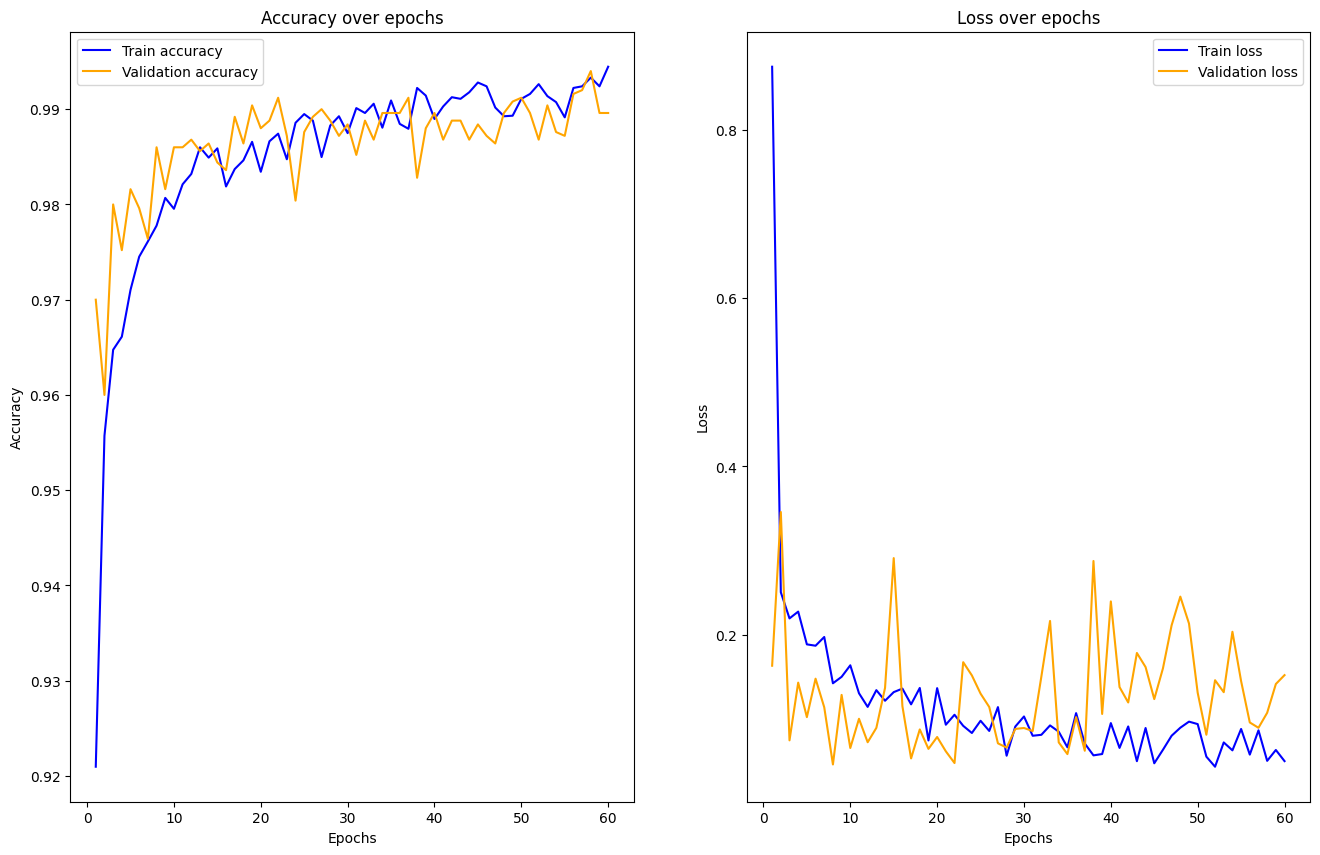

In [11]:
resnet50_stats = load_stats(resnet50_model)
graph_accuracy_and_loss(resnet50_stats, f'./images/{resnet50_model.name}/accuracy_loss.png')

Konačno, možemo ispitati performanse naučenog modela na skupu za ispitivanje (_test set_).

In [12]:
def get_model_weights_path(model):
    return f'./models/{model.name}/model'


resnet50_model = get_resnet_50()
resnet50_model.load_weights(get_model_weights_path(resnet50_model))

results = resnet50_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 12s 36ms/step - loss: 0.0910 - accuracy: 0.9932


Ove rezultate dodatno ćemo formatirati zbog ljepšeg ispisa, a onda i pohraniti u stats direktorij.

In [13]:
def print_results(model, results):
    print(f'Model: {model.name}')
    print(f'Test accuracy: {results[1]}')
    print(f'Test loss: {results[0]}')

    with open(f'./stats/{model.name}/test_stats', 'w') as file:
        file.write(f'Test accuracy: {results[1]}\n')
        file.write(f'Test loss: {results[0]}')

print_results(resnet50_model, results)

Model: ResNet50
Test accuracy: 0.9932000041007996
Test loss: 0.09095156937837601


Sada kada smo prikazali testnu preciznost i gubitak, ostaje nam još prikazati konfuzijsku matricu i nekoliko mjera dobrote. Dodatno kreiramo fuknciju za dohvat predikcija.

In [14]:
def get_class_predictions(model):
    model_predictions = model.predict(test_generator)
    return np.argmax(model_predictions, axis=1)

Dohvatimo sada predikcije klasa.

In [15]:
resnet50_class_predictions = get_class_predictions(resnet50_model)

313/313 [==============================] - 10s 31ms/step


Kreirajmo funkciju za prikaz konfuzijske matrice.

In [16]:
def show_confusion_matrix(model, class_predictions):
    confusiom_mat = confusion_matrix(test_generator.classes, class_predictions)

    plt.figure(figsize=(15, 5))
    plt.imshow(confusiom_mat, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.colorbar()

    for i, val in enumerate(test_generator.class_indices.keys()):
        print(f"Class {i} is for {val}.")

    plt.tight_layout()
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')

    thresh = confusiom_mat.max() / 2.
    cm_color = lambda x: "white" if x > thresh else "black"
    for i, row in enumerate(confusiom_mat):    
        for j, col in enumerate(confusiom_mat[i]):
            percentage = round(confusiom_mat[i, j]/len(class_predictions) * 100, 2)
            text = f"{confusiom_mat[i, j]}\n{percentage}%"
            plt.text(j, i, text, horizontalalignment="center", verticalalignment="center", color=cm_color(confusiom_mat[i, j]))

    return confusiom_mat

Potom prikažimo konfucijsku matricu.

Class 0 is for Colon Adenocarcinoma.
Class 1 is for Colon Benign Tissue.
Class 2 is for Lung Adenocarcinoma.
Class 3 is for Lung Benign Tissue.
Class 4 is for Lung Squamous Cell Carcinoma.


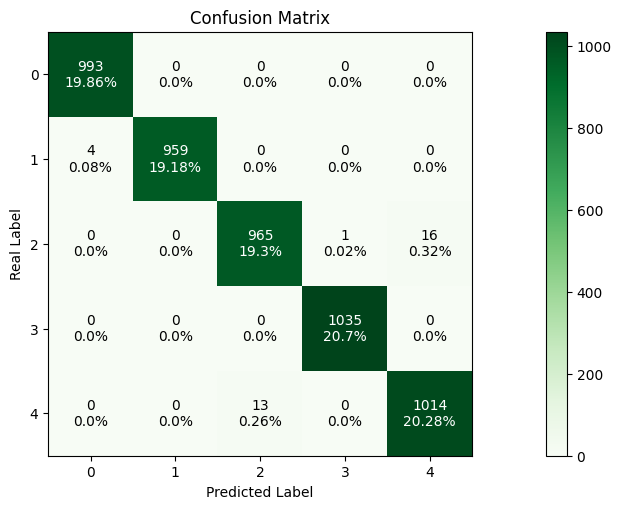

In [17]:
resnet50_conf_matrix = show_confusion_matrix(resnet50_model, resnet50_class_predictions)

Isto tako, kreiramo funkciju za prikaz raznih grafova performansi.

In [18]:
def show_performance_graphs(conf_matrix):
    N = np.sum(np.concatenate(conf_matrix))
    FP = np.sum(conf_matrix, axis=1)
    FN = np.sum(conf_matrix, axis=0)

    x = np.arange(len(classes))
    width = 0.13
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    accs = []
    precs = []
    F1s = []
    recs = []
    specs = []

    for i in range(len(conf_matrix)):
        TP_i = conf_matrix[i, i]
        FP_i = FP[i] - TP_i
        FN_i = FN[i] - TP_i
        TN_i = N - TP_i - FP_i - FN_i

        acc = (TP_i + TN_i) / (TN_i + TP_i + FN_i + FP_i) * 100
        prec = (TP_i) / (TP_i + FP_i) * 100
        F1 = (TP_i) / (TP_i + 0.5 * (FN_i + FP_i)) * 100
        rec = (TP_i) / (TP_i + FN_i) * 100
        spec = (TN_i) / (TN_i + FP_i) * 100

        accs.append(round(acc, 2))
        precs.append(round(prec,2))
        F1s.append(round(F1,2))
        recs.append(round(rec,2))
        specs.append(round(spec,2))

    measurements = {"Accuracy": accs, "Precision": precs, "F-1 Score": F1s, "Recall": recs, "Specificity": specs}
    colors = ["orange", "yellow", "green", "brown", "blue"]

    for i, item in enumerate(measurements.items()):
        key, val = item
        measurement = (val[0], val[1], val[2], val[3], val[4])

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width=width-0.02, label=key, color=colors[i])
        ax.bar_label(rects, padding=3, rotation=45)
        multiplier += 1

    ax.set_title('Mjere dobrote po klasi')
    ax.set_ylabel("Percentage (%) ")
    ax.set_xticks(x + width + 0.1, classes)
    ax.legend(loc='upper left', ncols=5)
    ax.set_ylim(95, 102)

    fig.set_figwidth(15)
    fig.set_figheight(5)

    plt.show()

Prakažimo grafove performansi.

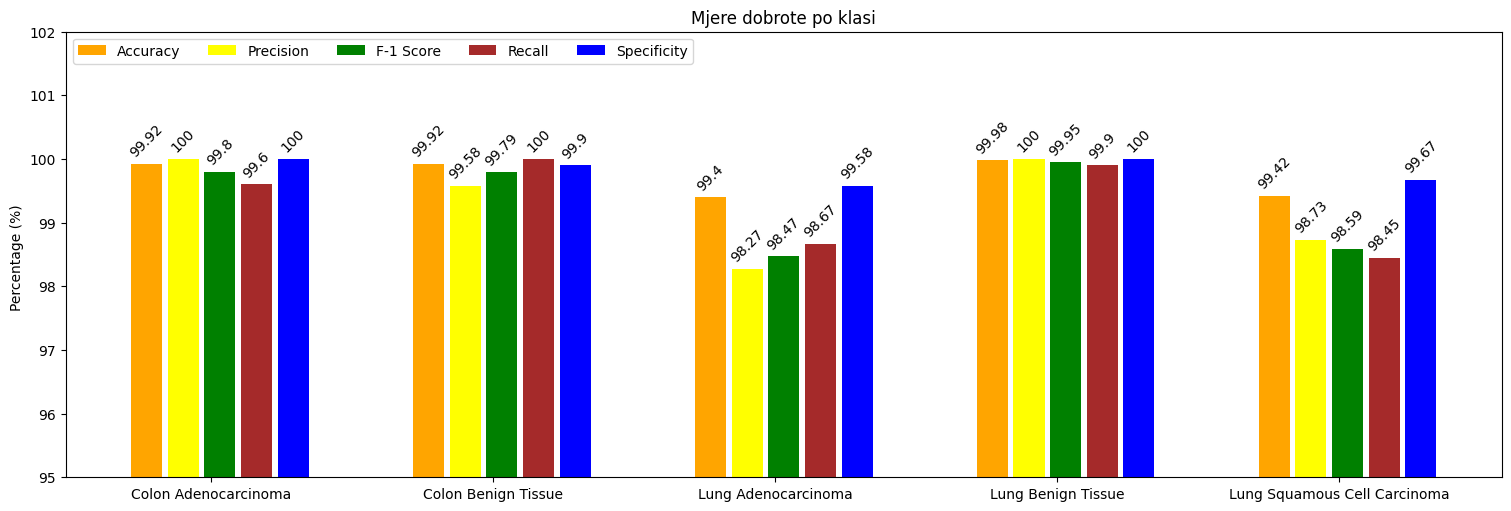

In [19]:
show_performance_graphs(resnet50_conf_matrix)

Osim prethodno odrađene Resnet50 mreže, postoji niz drugih mreža koje smo mogli isprobati, jedna od njih je MobileNetV2 mreža koja radi sa znatno manja parametara pa je pogodna za ugradnju u embeded uređaje. Dodatna razlika u odnosu na prethodnu mrežu je manjak slojeva koje dodajemo na izlaz te sada još i treniramo cijelu mrežu.

In [20]:
def get_mobilenet_v2():
    pretrained_model = MobileNetV2(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = True

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ], name='MobileNetV2')

    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mobile_net_v2_model = get_mobilenet_v2()
mobile_net_v2_model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 1280)        5120      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 5)                 313605    
                                                                 
Total params: 2576709 (9.83 MB)
Trainable params: 2540037 (9.69 MB)
Non-trainable params: 36672 (143.25 KB)
_________________________________________________________________


Pokrenimo sada treniranje našeg MobileNetV2 modela.

In [21]:
num_epochs = 60
mobile_net_v2_model = get_mobilenet_v2()
train_model(mobile_net_v2_model, num_epochs)

Epoch 1/60
1094/1094 [==============================] - 68s 49ms/step - loss: 2.4953 - accuracy: 0.7905 - val_loss: 636.3812 - val_accuracy: 0.2108
Epoch 2/60
1094/1094 [==============================] - 50s 45ms/step - loss: 1.4989 - accuracy: 0.8698 - val_loss: 225.5470 - val_accuracy: 0.3756
Epoch 3/60
1094/1094 [==============================] - 49s 45ms/step - loss: 0.9320 - accuracy: 0.8986 - val_loss: 241.2691 - val_accuracy: 0.3252
Epoch 4/60
1094/1094 [==============================] - 50s 45ms/step - loss: 0.6311 - accuracy: 0.9186 - val_loss: 9.1263 - val_accuracy: 0.6376
Epoch 5/60
1094/1094 [==============================] - 50s 45ms/step - loss: 0.3333 - accuracy: 0.9350 - val_loss: 5.6505 - val_accuracy: 0.7088
Epoch 6/60
1094/1094 [==============================] - 50s 46ms/step - loss: 0.4062 - accuracy: 0.9251 - val_loss: 4.5791 - val_accuracy: 0.7428
Epoch 7/60
1094/1094 [==============================] - 51s 47ms/step - loss: 0.2651 - accuracy: 0.9407 - val_loss: 1.

Prikažimo grafikone treniranja MobileNetV2.

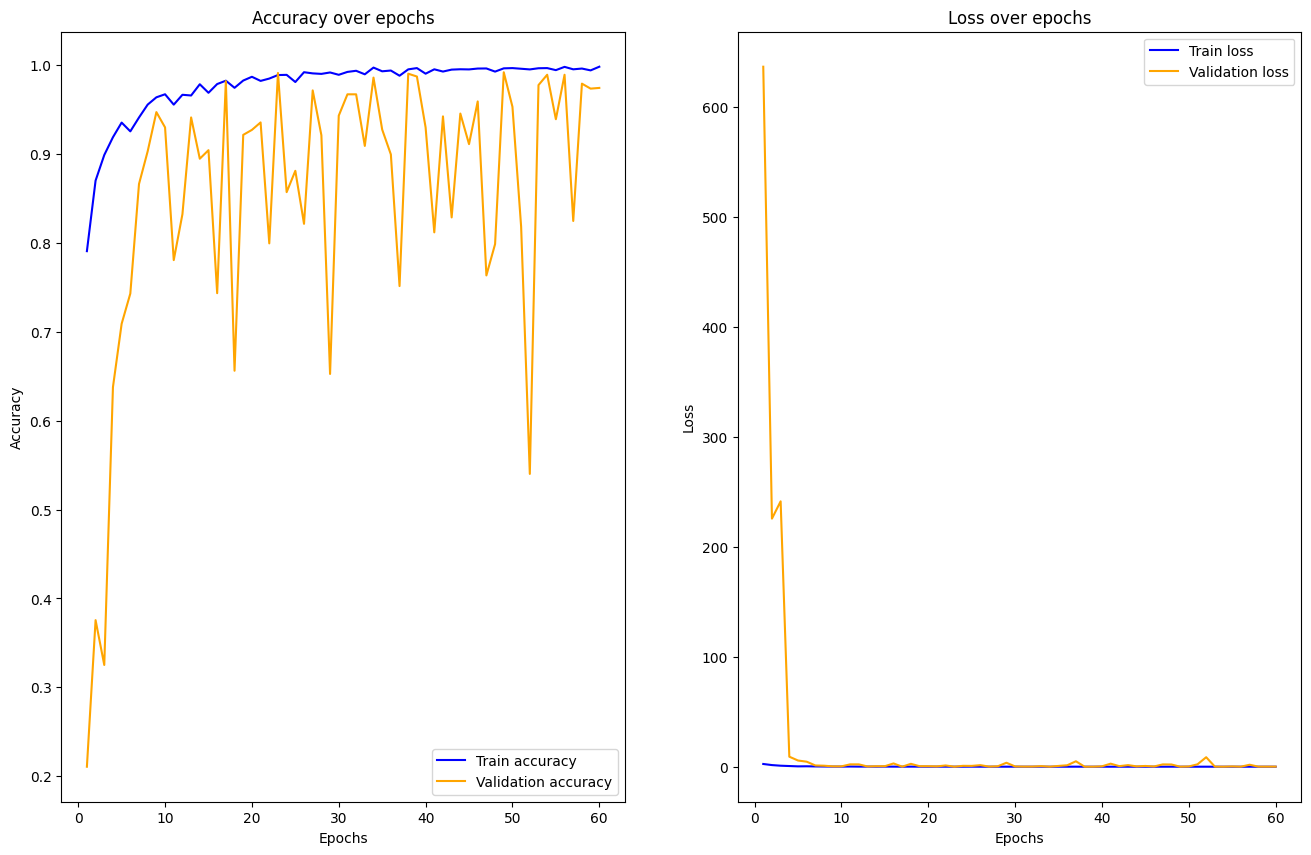

In [22]:
mobilenet_v2_stats = load_stats(mobile_net_v2_model)
graph_accuracy_and_loss(mobilenet_v2_stats, f'./images/{mobile_net_v2_model.name}/accuracy_loss.png')

Dohvatimo konačan model.

In [23]:
mobilenet_v2_model = get_mobilenet_v2()
mobilenet_v2_model.load_weights(get_model_weights_path(mobilenet_v2_model))
mobilenet_results = mobilenet_v2_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 8s 23ms/step - loss: 0.0469 - accuracy: 0.9866


I konačno ispišimo njegove performanse.

In [24]:
print_results(mobile_net_v2_model, mobilenet_results)

Model: MobileNetV2
Test accuracy: 0.9865999817848206
Test loss: 0.04689840227365494


Naravno, dodatno možemo pogledati konfuzijsku matricu i prikaz raznih statistika. Započnimo to dohvatom predikcija klasa.

In [25]:
mobilenet_v2_class_predictions = get_class_predictions(mobilenet_v2_model)

313/313 [==============================] - 7s 21ms/step


Sada prikažimo konfizijsku matricu.

Class 0 is for Colon Adenocarcinoma.
Class 1 is for Colon Benign Tissue.
Class 2 is for Lung Adenocarcinoma.
Class 3 is for Lung Benign Tissue.
Class 4 is for Lung Squamous Cell Carcinoma.


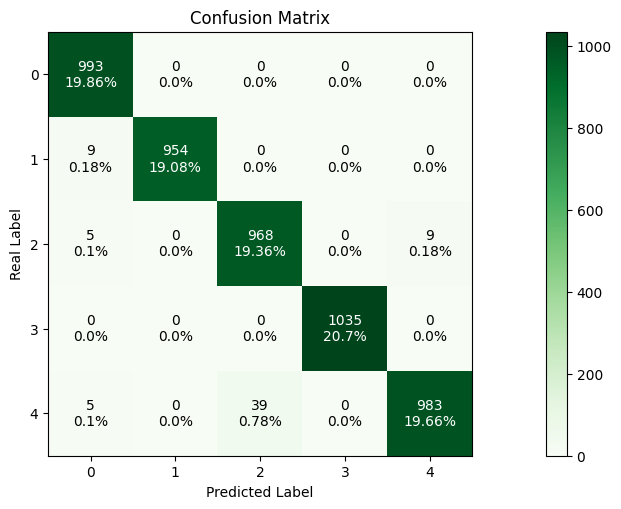

In [26]:
mobilenet_v2_conf_matrix = show_confusion_matrix(mobilenet_v2_model, mobilenet_v2_class_predictions)

Iz konfuzijske matrice vidimo kako model ima problema s klasifikacijom "Lung Adenocarcinoma" koji se zna klasificirati kao "Lung Squamous Cell Carcinoma".  
Posljednje prikažimo razne grafikone performansi.

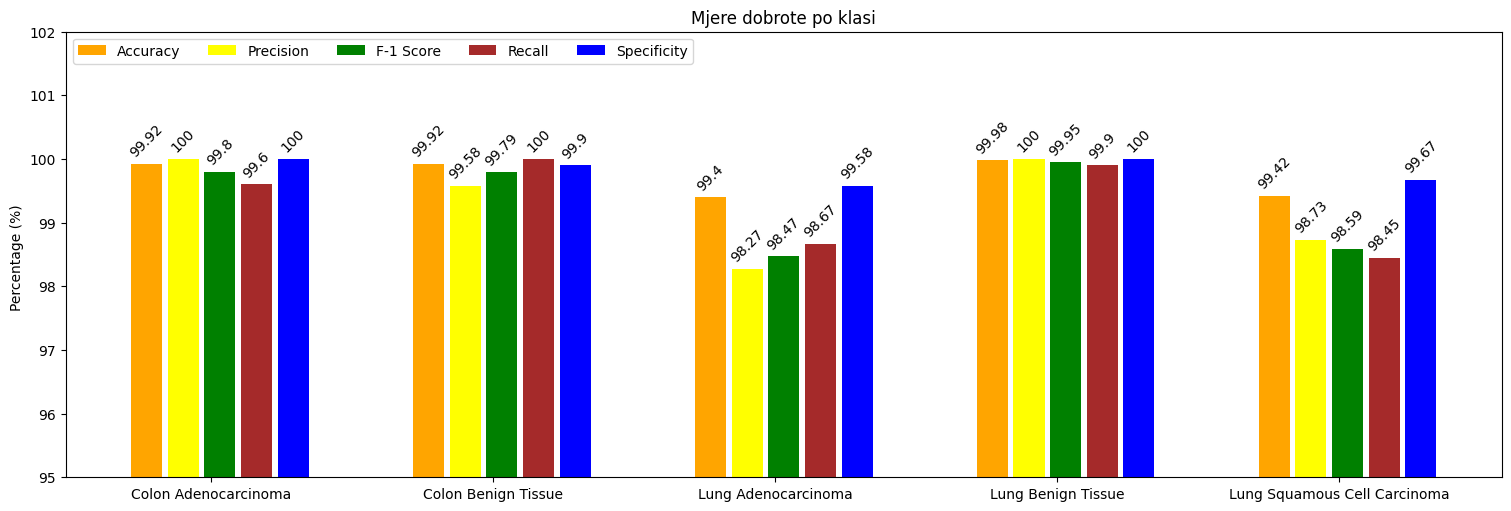

In [27]:
show_performance_graphs(resnet50_conf_matrix)